In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy.linalg import inv

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

# Q4 - A first Gibbs sampler

## Point 1

In [3]:
# Sample from distribution p(s1,s2|t,y) 
def sample_s(x_b, mu_a, A, b, sigma_a, sigma_ba):
    
    # Calculate Sigma_{a|b}
    sigma_ab = inv(inv(sigma_a) + A.T@inv(sigma_ba)@A)
    
    # Calculate mu_{a|b}
    mu_ab = sigma_ab@(inv(sigma_a)@mu_a + A.T@inv(sigma_ba)@(x_b-b))
    
    # Return N(mu_{a|b}, Sigma_{a|b})
    return multivariate_normal.rvs(mu_ab.reshape(-1), sigma_ab)

# Sample from distribution p(t|s1,s2,y). 
def sample_t(y, s1, s2, sigma_ba):
    
    mean = s1 - s2
    
    # Do moment-matching
    if y == 1:
        a, b = 0, np.Inf
    else:
        a, b = np.NINF , 0
    
    # Scale a, b
    a_scaled, b_scaled = (a - mean) / np.sqrt(sigma_ba), (b - mean) / np.sqrt(sigma_ba)
    
    # Return truncated norm (result from Q3 - 2)
    return truncnorm.rvs(a_scaled, b_scaled, mean, sigma_ba)

# Gibbs sampler
def gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init):
    s1_samples = np.zeros(n_samples)
    s2_samples = np.zeros(n_samples)
    s1_samples[0] = s_init[0]
    s2_samples[0] = s_init[1]
    for i in range(1, n_samples):
        t = sample_t(y, s1_samples[i-1], s2_samples[i-1], sigma_ba)
        s1_samples[i], s2_samples[i] = sample_s(t, mu_a, A, b, sigma_a, sigma_ba)
    return s1_samples[burn:], s2_samples[burn:]

In [4]:
# Set values
mu_a = np.array([[1, 1]]).T
A = np.array([[1,-1]])
b = np.array([[0]])
sigma_a = np.array([[1,0],[0,1]])
sigma_ba = np.array([[1]])
y = 1

### First run

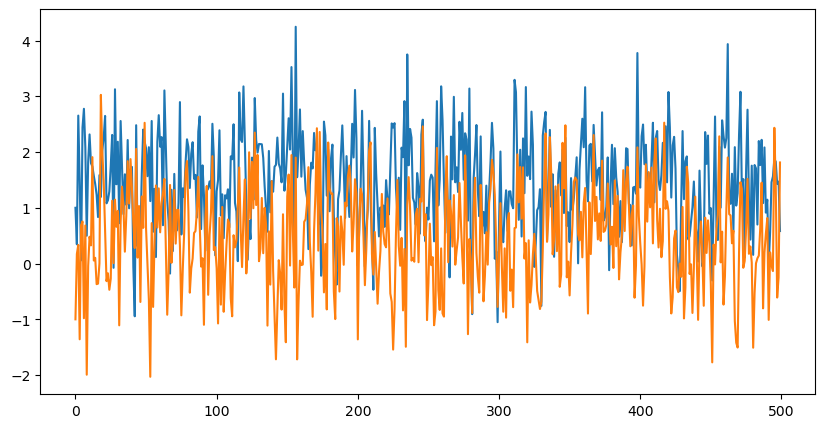

1.4807348475281614
0.4653475586616416


In [5]:
n_samples = 500
s_init = [1,-1]
burn = 0
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)
plt.plot(s1)
plt.plot(s2)
plt.show()

print(np.mean(s1))
print(np.mean(s2))

### Analyze burn-in

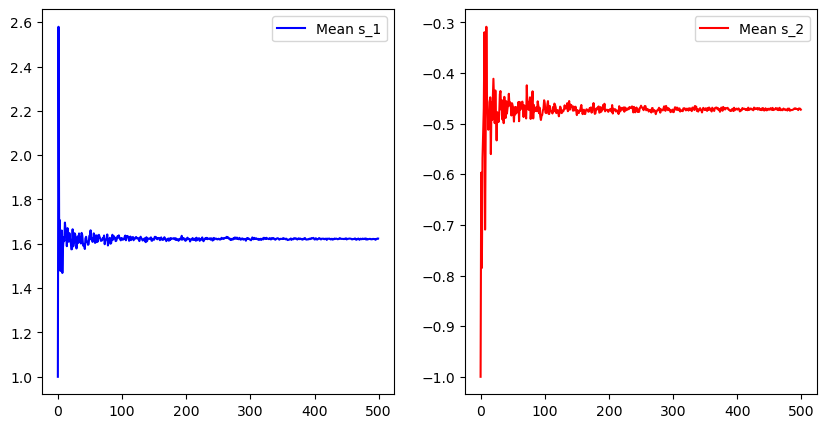

In [6]:
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)

def getMeans(samples):
    for i in range(0, len(samples)):
        samples[i] = np.sum(samples[:i+1])/(i+1)
    return samples

means_s1 = getMeans(s1)
means_s2 = getMeans(s2)

plt.figure(1)
plt.subplot(1, 2, 1)
plt.plot(means_s1,label="Mean s_1", color='blue')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(means_s2,label="Mean s_2", color='red')
plt.legend()
plt.show()

### Conclusion: choose burn in ~100

### Second run

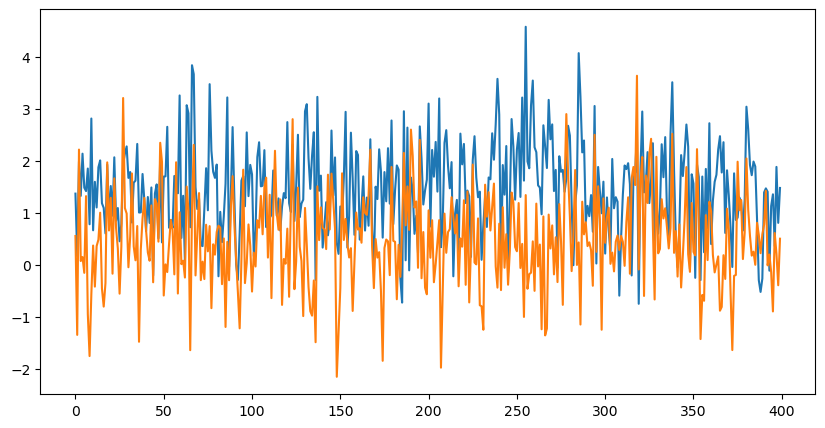

1.4785206302997005
0.47639911780597727


In [7]:
burn = 100
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)
plt.plot(s1)
plt.plot(s2)
plt.show()

print(np.mean(s1))
print(np.mean(s2))

## Second point 

In [8]:
# Take samples from gibbs sampler and transform into gaussian distributions
def gauss_transform(samples, xs):
    s_mean = np.mean(samples)
    s_cov = np.cov(samples)
    gaussian = multivariate_normal.pdf(xs, s_mean, s_cov, n_samples)
    return gaussian

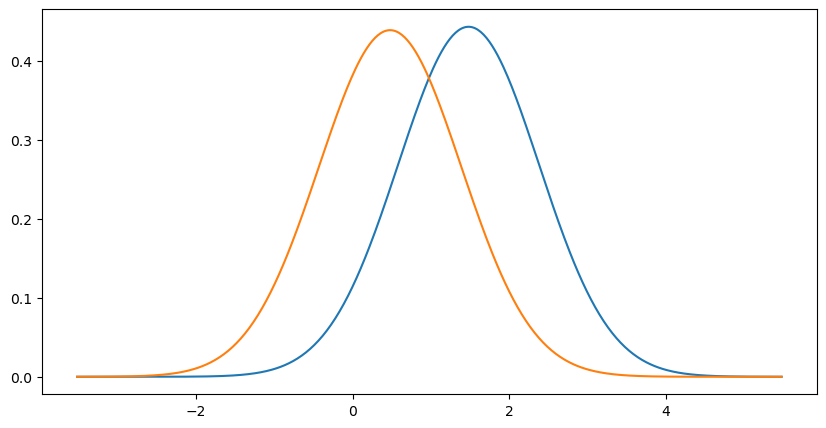

In [9]:
xs = np.linspace(np.mean(s1)-5, np.mean(s2)+5, n_samples)
s1_gauss = gauss_transform(s1, xs)
s2_gauss = gauss_transform(s2, xs)

plt.plot(xs, s1_gauss)
plt.plot(xs, s2_gauss)
plt.show()